# iCAT Correlate
---

In [1]:
from pathlib import Path
import re
from functools import partial
import warnings

from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
from shapely.geometry import box
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from skimage import img_as_uint
from skimage.color import rgb2grey
from skimage.measure import ransac
from skimage.transform import AffineTransform as AffineSkimage
from skimage.external.tifffile import TiffWriter

import renderapi
from renderapi.transform import AffineModel as AffineRender
from renderapi.tilespec import TileSpec
from renderapi.layout import Layout
from renderapi.client import (SiftPointMatchOptions,
                              MatchDerivationParameters,
                              FeatureExtractionParameters,
                              ArgumentParameters)

## 1 Create lil EM-based "mini-montages"
---

* Set up render-ws environment
* Find the (unmontaged) lil EM tiles that overlap with each big EM tile
* Render mini-montage from corresponding lil EM montaged tiles
* Export mini-montage to disk
* Create mini-montage stack
* Inspect mini-montages

### 1.1 Set up `render-ws` environment

In [2]:
owner = 'rlane'  # replace with your name
project = '20190517_UMCG_RL005'
project_dir = Path(f'/long_term_storage/{owner}/SECOM/projects/{project}')

# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'sonic',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '5G'
}

render = renderapi.connect(**render_connect_params)
stacks_all = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_EM = [stack for stack in stacks_all if 'EM' in stack]
stacks_FM = [stack for stack in stacks_all if stack not in stacks_EM]

# Set match collection
match_collection = f'{project}_big_EM_mm_EM_points'

out = f"""\
owner............... {owner}
project............. {project}
project directory... {project_dir}
all stacks.......... {stacks_all}
EM stacks........... {stacks_EM}
FM stacks........... {stacks_FM}
match collection.... {match_collection}
"""
print(out)

owner............... rlane
project............. 20190517_UMCG_RL005
project directory... /long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005
all stacks.......... ['hoechst_overlaid', 'lil_EM_montaged', 'lil_EM', 'hoechst', 'big_EM']
EM stacks........... ['lil_EM_montaged', 'lil_EM', 'big_EM']
FM stacks........... ['hoechst_overlaid', 'hoechst']
match collection.... 20190517_UMCG_RL005_big_EM_mm_EM_points



### 1.2 Get stack data

In [3]:
tile_spec_cols = ['tileId', 'z', 'width', 'height',
                  'imageCol', 'imageRow', 'pixelsize',
                  'minIntensity', 'maxIntensity',
                  'filepath', 'layout', 'transforms']
stack_data = pd.DataFrame(columns=['stack', 'section'] + tile_spec_cols)

i = 0
for stack in tqdm_notebook(stacks_all):
    
    # Get pixelsize from stackResolution
    stack_metadata = renderapi.stack.get_stack_metadata(stack, render=render)
    ps_x = stack_metadata.stackResolutionX
    ps_y = stack_metadata.stackResolutionY
    pixelsize = (ps_x + ps_y) / 2
    
    # Get z values for each stack
    z_vals = renderapi.stack.get_z_values_for_stack(stack, render=render)
    # Loop through z values
    for z in z_vals:
        
        # Get sectionId for z value
        section = renderapi.stack.get_sectionId_for_z(stack=stack,
                                                      z=z,
                                                      render=render)
        # Iterate through `TileSpec`s
        tile_specs = renderapi.tilespec.get_tile_specs_from_z(stack=stack,
                                                              z=z,
                                                              render=render)
        for ts in tile_specs:
            
            # Build up stack data
            stack_data.loc[i] = pd.Series(ts.to_dict())
            stack_data.loc[i, 'stack'] = stack
            stack_data.loc[i, 'section'] = section
            stack_data.loc[i, 'pixelsize'] = pixelsize
            stack_data.loc[i, 'imageCol'] = ts.layout.imageCol
            stack_data.loc[i, 'imageRow'] = ts.layout.imageRow
            stack_data.loc[i, 'filepath'] = Path(ts.ip['0'].imageUrl.split('://')[1])

            # Increment index
            i += 1

# Preview
stack_data = stack_data.infer_objects()
preview_cols = ['stack', 'section', 'tileId', 'z',
                'width', 'height', 'pixelsize',
                'imageCol', 'imageRow',
                'minIntensity', 'maxIntensity']
stack_data[preview_cols].groupby(['stack', 'section']).apply(lambda x: x.sample(3))

stack section  \
stack            section                                  
big_EM           S001    2400            big_EM    S001   
                         2401            big_EM    S001   
                         2404            big_EM    S001   
hoechst          S001    2382           hoechst    S001   
                         2384           hoechst    S001   
                         2388           hoechst    S001   
hoechst_overlaid S001    6     hoechst_overlaid    S001   
                         0     hoechst_overlaid    S001   
                         8     hoechst_overlaid    S001   
lil_EM           S001    1322            lil_EM    S001   
                         1898            lil_EM    S001   
                         1911            lil_EM    S001   
lil_EM_montaged  S001    1113   lil_EM_montaged    S001   
                         718    lil_EM_montaged    S001   
                         857    lil_EM_montaged    S001   

                                                     tileId    z   width  \
stack            section                                                   
big_EM           S001    2400   aai_big_EM-S001-00000x00001  1.0  4096.0   
                         2401   aaj_big_EM-S001-00001x00001  1.0  4096.0   
                         2404   aam_big_EM-S001-00003x00000  1.0  4096.0   
hoechst          S001    2382  aag_hoechst-S001-00001x00002  1.0  2048.0   
                         2384  aai_hoechst-S001-00000x00001  1.0  2048.0   
                         2388  aam_hoechst-S001-00003x00000  1.0  2048.0   
hoechst_overlaid S001    6     aag_hoechst-S001-00001x00002  1.0  2048.0   
                         0     aaa_hoechst-S001-00000x00003  1.0  2048.0   
                         8     aai_hoechst-S001-00000x00001  1.0  2048.0   
lil_EM           S001    1322   aew_lil_EM-S001-00021x00030  1.0  4096.0   
                         1898   bba_lil_EM-S001-00030x00014  1.0  4096.0   
                         1911   bbn_lil_EM-S001-00017x00014  1.0  4096.0   
lil_EM_montaged  S001    1113   bqf_lil_EM-S001-00023x00002  1.0  4096.0   
                         718    bba_lil_EM-S001-00030x00014  1.0  4096.0   
                         857    bgj_lil_EM-S001-00023x00010  1.0  4096.0   

                               height   pixelsize  imageCol  imageRow  \
stack            section                                                
big_EM           S001    2400  4096.0   36.473647       0.0       1.0   
                         2401  4096.0   36.473647       1.0       1.0   
                         2404  4096.0   36.473647       3.0       0.0   
hoechst          S001    2382  2048.0  110.345320       1.0       2.0   
                         2384  2048.0  110.345320       0.0       1.0   
                         2388  2048.0  110.345320       3.0       0.0   
hoechst_overlaid S001    6     2048.0    1.000000       1.0       2.0   
                         0     2048.0    1.000000       0.0       3.0   
                         8     2048.0    1.000000       0.0       1.0   
lil_EM           S001    1322  4096.0    4.841607      21.0      30.0   
                         1898  4096.0    4.841607      30.0      14.0   
                         1911  4096.0    4.841607      17.0      14.0   
lil_EM_montaged  S001    1113  4096.0    1.000000      23.0       2.0   
                         718   4096.0    1.000000      30.0      14.0   
                         857   4096.0    1.000000      23.0      10.0   

                               minIntensity  maxIntensity  
stack            section                                   
big_EM           S001    2400           0.0       65535.0  
                         2401           0.0       65535.0  
                         2404           0.0       65535.0  
hoechst          S001    2382        1075.0        4738.5  
                         2384        1075.0        4738.5  
                         2388        1075.0        4738.5  
hoechst_overlaid S001  

### 1.3 Find overlapping tiles
Find the (unmontaged) lil EM tiles that overlap with each big EM tile.
Will store this information in a `DataFrame` resembling
```python
[1]:  overlapping_tiles

[1]: section  z  big EM tileId                  lil EM tileIds
     S001     1  'aaa_big_EM-S001-00001x00001'  ['aaa_lil_EM-S001-00012x00013','aab_lil_EM-S001-00013x00013',...]
     S001     1  'aab_big_EM-S001-00002x00001'  ['aaq_lil_EM-S001-00027x00012','aar_lil_EM-S001-00026x00012',...]
     S001     1  'aad_big_EM-S001-00001x00000'  ['aek_lil_EM-S001-00025x00006','ael_lil_EM-S001-00024x00006',...]
     ...
     S004     4  'aad_big_EM-S004-00003x00003'  ['aio_lil_EM-S004-00013x00000','aip_lil_EM-S004-00012x00000',...]
```

For this to be done correctly, we need to look at the tiles as they are in "real" physical space (i.e. based on their FOV and stage position (all in microns)). Since tiles are imported into `render-ws` in "pixel" space and the pixel size gets omitted from the specification, this is unfortunately complicated. Nonetheless, we can create some functionality to transform into real physical space.

In [4]:
def bboxes_overlap(bbox_1, bbox_2):
    """Determines if two bounding boxes overlap or coincide
    
    Parameters
    ----------
    bbox_1 : 4-tuple
        1st bounding box in (minX, minY, maxX, maxY) notation
        
    bbox_2 : 4-tuple
        2nd bounding box in (minX, minY, maxX, maxY) notation
    
    Returns
    -------
    overlap : bool
        True if bounding boxes overlap / coincide
        False otherwise
    """
    # 2 tiles overlap iff their projections onto both x and y axis overlap
    # Overlap in 1D iff box1_max > box2_min AND box1_min < box2_max
    overlap = ((bbox_1[2] >= bbox_2[0]) and (bbox_1[0] <= bbox_2[2])) and \
              ((bbox_1[3] >= bbox_2[1]) and (bbox_1[1] <= bbox_2[3]))
    return overlap

In [5]:
# Initialize overlapping tiles DataFrame
cols_mm = ['stack', 'section', 'z', 'tileId']
df_mm = stack_data[cols_mm].groupby('stack').get_group('big_EM').copy()
df_mm['tileIds_lil_EM'] = None
df_mm.rename(columns={'tileId': 'tileId_big_EM'}, inplace=True)
df_mm.drop(columns='stack', inplace=True)

# Loop through big EM tiles and find to find overlapping lil EM tiles
for i, tile_big_EM in tqdm_notebook(df_mm.iterrows(), total=len(df_mm)):
    
    # Get physical bounding box (in um) of big EM tile from stage position
    tile_data_big_EM = stack_data.loc[i, :]
    x0 = tile_data_big_EM['layout']['stageX']  # um
    y0 = tile_data_big_EM['layout']['stageY']  # um
    w = tile_data_big_EM['width'] * tile_data_big_EM['pixelsize']/1e3   # um
    h = tile_data_big_EM['height'] * tile_data_big_EM['pixelsize']/1e3  # um
    bbox_big_EM = box(x0-w/2, y0-h/2, x0+w/2, y0+h/2)
    
    # Loop through lil EM tiles
    overlapping_tiles = []
    stack_data_lil_EM = stack_data.loc[stack_data['stack'] == 'lil_EM', :]
    for j, tile_data_lil_EM in stack_data_lil_EM.iterrows():
        
        # Get physical bounding box (in um) of lil EM tile from stage position
        x0 = tile_data_lil_EM['layout']['stageX']  # um
        y0 = tile_data_lil_EM['layout']['stageY']  # um
        w = tile_data_lil_EM['width'] * tile_data_lil_EM['pixelsize']/1e3   # um
        h = tile_data_lil_EM['height'] * tile_data_lil_EM['pixelsize']/1e3  # um
        bbox_lil_EM = box(x0-w/2, y0-h/2, x0+w/2, y0+h/2)
        
        # Determine if big EM and lil EM tiles overlap
        if bboxes_overlap(bbox_big_EM.bounds,
                          bbox_lil_EM.bounds):
            overlapping_tiles.append(tile_data_lil_EM.tileId)
        
    # Store in overlapping tiles DataFrame
    df_mm.at[i, 'tileIds_lil_EM'] = overlapping_tiles

# Preview
df_mm.groupby('section').apply(lambda x: x.sample(4))

section    z                tileId_big_EM  \
section                                                  
S001    2399    S001  1.0  aah_big_EM-S001-00000x00002   
        2395    S001  1.0  aad_big_EM-S001-00003x00003   
        2396    S001  1.0  aae_big_EM-S001-00003x00002   
        2406    S001  1.0  aao_big_EM-S001-00001x00000   

                                                 tileIds_lil_EM  
section                                                          
S001    2399  [aio_lil_EM-S001-00000x00027, aip_lil_EM-S001-...  
        2395  [abg_lil_EM-S001-00032x00033, abh_lil_EM-S001-...  
        2396  [aju_lil_EM-S001-00032x00027, ajv_lil_EM-S001-...  
        2406  [bny_lil_EM-S001-00018x00004, bnz_lil_EM-S001-...

### 1.4 Create mini-montages
Use `render-ws` API to export a 4096px wide montaged lil EM image

* Collect montaged lil EM tiles corresponding to (nonmontaged) overlapping lil EM tiles
* Get bounding boxes for collections of montaged lil EM tiles
* Render minimontage image

In [6]:
# Add (empty) `TileSpec` columns
df_mm['tileId_mm_EM'] = None
df_mm['positionX'] = None
df_mm['positionY'] = None
df_mm['width'] = None
df_mm['height'] = None
df_mm['scale'] = None
df_mm['imageUrl'] = None

for i in tqdm_notebook(df_mm.index):
    
    # Get bounding box of each overlapping montaged lil EM tile
    boundss = []
    for tileId_lil_EM in df_mm.loc[i, 'tileIds_lil_EM']:
        ts_montaged = renderapi.tilespec.get_tile_spec(stack='lil_EM_montaged',
                                                       tile=tileId_lil_EM,
                                                       render=render)
        boundss.append(ts_montaged.bbox)
    
    # Determine bounding box for each collection of montaged lil EM tiles
    bounds_data = pd.DataFrame(boundss, columns=['minX', 'minY', 'maxX', 'maxY'])
    xywh = (bounds_data['minX'].min(),
            bounds_data['minY'].min(),
            bounds_data['maxX'].max() - bounds_data['minX'].min(),
            bounds_data['maxY'].max() - bounds_data['minY'].min())
    scale = np.round(4096/xywh[2], 5)
    
    # Render bounding box image
    image_bb = renderapi.image.get_bb_image('lil_EM_montaged',
                                            df_mm.loc[i, 'z'],
                                            *xywh,
                                            scale=scale,
                                            img_format='tif',
                                            render=render)
    
    # Convert to grey scale 16-bit image
    with warnings.catch_warnings():      # Suppress precision
        warnings.simplefilter('ignore')  # loss warnings
        image_mm = img_as_uint(rgb2grey(image_bb))
    
    # Set minimontage filepath
    section = df_mm.loc[i, 'section']
    col, row = stack_data.loc[i, ['imageCol', 'imageRow']].astype(int)
    fp_dir = project_dir / section / 'mm_EM'
    fp = fp_dir / f'mm_EM-{section}-{col:05d}x{row:05d}.tif'
    fp_dir.mkdir(parents=False, exist_ok=True)
    # Save to disk with `TiffWriter`
    with TiffWriter(fp.as_posix()) as tif:
        tif.save(image_mm)
        
    # Add tile specifications to minimontage DataFrame
    df_mm.loc[i, 'tileId_mm_EM'] = fp.stem
    df_mm.loc[i, ['positionX', 'positionY']] = xywh[:2]
    df_mm.loc[i, ['width', 'height']] = image_mm.shape[::-1]
    df_mm.loc[i, 'scale'] = scale
    df_mm.loc[i, 'imageUrl'] = fp.as_uri()

# Preview
df_mm.head()

,section,z,tileId_big_EM,tileIds_lil_EM,tileId_mm_EM,positionX,positionY,width,height,scale,imageUrl
2392,S001,1.0,aaa_big_EM-S001-00000x00003,"[aaa_lil_EM-S001-00000x00033, aab_lil_EM-S001-...",mm_EM-S001-00000x00003,17,107775,4095,2373,0.15839,file:///long_term_storage/rlane/SECOM/projects...
2393,S001,1.0,aab_big_EM-S001-00001x00003,"[aaj_lil_EM-S001-00009x00033, aak_lil_EM-S001-...",mm_EM-S001-00001x00003,32397,107785,4095,1668,0.11137,file:///long_term_storage/rlane/SECOM/projects...
2394,S001,1.0,aac_big_EM-S001-00002x00003,"[aav_lil_EM-S001-00021x00033, aaw_lil_EM-S001-...",mm_EM-S001-00002x00003,75649,107795,4096,1851,0.1235,file:///long_term_storage/rlane/SECOM/projects...
2395,S001,1.0,aad_big_EM-S001-00003x00003,"[abg_lil_EM-S001-00032x00033, abh_lil_EM-S001-...",mm_EM-S001-00003x00003,115314,105529,4096,3790,0.21905,file:///long_term_storage/rlane/SECOM/projects...
2396,S001,1.0,aae_big_EM-S001-00003x00002,"[aju_lil_EM-S001-00032x00027, ajv_lil_EM-S001-...",mm_EM-S001-00003x00002,115307,64975,4095,7903,0.21853,file:///long_term_storage/rlane/SECOM/projects...


### 1.5 Create mini-montage stack

* Create `TileSpec`s
* Import `TileSpec`s

In [7]:
for i, tile_mm in df_mm.iterrows():
    
    # Get transform data
    M00 = 1 / tile_mm['scale']
    M11 = 1 / tile_mm['scale']
    B0 = tile_mm['positionX']
    B1 = tile_mm['positionY']
    # Set transform
    at = AffineRender(M00=M00, M01=0, B0=B0,
                      M10=0, M11=M11, B1=B1)
    
    layout = Layout(sectionId=tile_mm['section'],
                    stageX=tile_mm['positionX'],
                    stageY=tile_mm['positionY'],
                    imageRow=stack_data.loc[i, 'imageRow'],
                    imageCol=stack_data.loc[i, 'imageCol'])
    # Build up minimontage DataFrame with remaining `TileSpec` parameters
    df_mm.loc[i, 'minint'] = 0
    df_mm.loc[i, 'maxint'] = 65535
    df_mm.loc[i, 'layout'] = layout
    df_mm.loc[i, 'tforms'] = [[at]]
    
# Preview
cols_ts = ['section', 'z', 'tileId_mm_EM', 'width', 'height', 'imageUrl', 'tforms']
df_mm[cols_ts].head()

,section,z,tileId_mm_EM,width,height,imageUrl,tforms
2392,S001,1.0,mm_EM-S001-00000x00003,4095,2373,file:///long_term_storage/rlane/SECOM/projects...,"[M=[[6.313530,0.000000],[0.000000,6.313530]] B..."
2393,S001,1.0,mm_EM-S001-00001x00003,4095,1668,file:///long_term_storage/rlane/SECOM/projects...,"[M=[[8.979079,0.000000],[0.000000,8.979079]] B..."
2394,S001,1.0,mm_EM-S001-00002x00003,4096,1851,file:///long_term_storage/rlane/SECOM/projects...,"[M=[[8.097166,0.000000],[0.000000,8.097166]] B..."
2395,S001,1.0,mm_EM-S001-00003x00003,4096,3790,file:///long_term_storage/rlane/SECOM/projects...,"[M=[[4.565168,0.000000],[0.000000,4.565168]] B..."
2396,S001,1.0,mm_EM-S001-00003x00002,4095,7903,file:///long_term_storage/rlane/SECOM/projects...,"[M=[[4.576031,0.000000],[0.000000,4.576031]] B..."


In [8]:
tile_specs_mm_EM = []
for i, tile_mm in tqdm_notebook(df_mm.iterrows(), total=len(df_mm)):
    
    # Create `TileSpec`
    ts_mm_EM = TileSpec(tileId=tile_mm['tileId_mm_EM'],
                        **tile_mm.to_dict())
    tile_specs_mm_EM.append(ts_mm_EM)

# Create stack
stack = 'mm_EM'
renderapi.stack.create_stack(stack=stack,
                             render=render)

# Import TileSpecs to render
renderapi.client.import_tilespecs(stack=stack,
                                  tilespecs=tile_specs_mm_EM,
                                  render=render)

# Set stack state to complete
renderapi.stack.set_stack_state(stack=stack,
                                state='COMPLETE',
                                render=render)

<Response [201]>

### 1.6 Inspect mini-montages
Things to check
* Image quality
* Alignment to montaged lil EM tiles

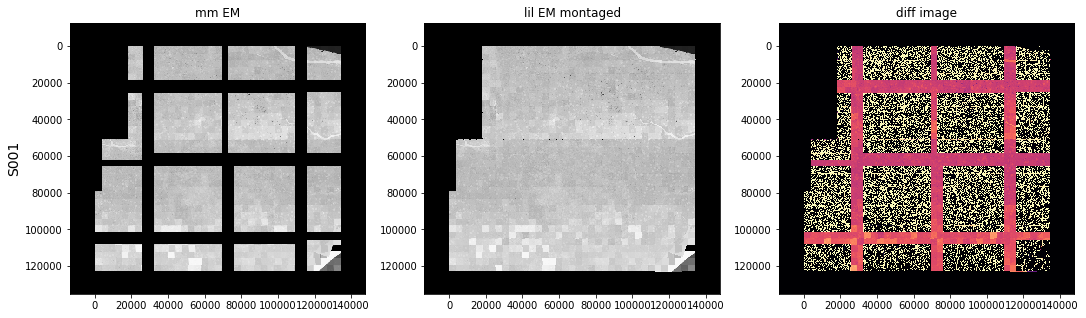

In [9]:
for (section, z), layer in tqdm_notebook(df_mm.groupby(['section', 'z'])):
    
    # Set oversized bounding box
    pct = 10  # %
    bounds = renderapi.stack.get_bounds_from_z(stack='mm_EM',
                                               z=z,
                                               render=render)
    x = bounds['minX']
    y = bounds['minY']
    w = bounds['maxX'] - bounds['minX']
    h = bounds['maxY'] - bounds['minY']
    bb = [x - (w * pct/100),
          y - (h * pct/100),
          w + (2*pct/100 * w),
          h + (2*pct/100 * h)]
    scale = 1024 / bb[2]
    
    # Render section images
    with warnings.catch_warnings():      # avoid loss of
        warnings.simplefilter('ignore')  # precision warning
        # Get oversized bounding box images
        image_mm_EM = img_as_uint(rgb2grey(renderapi.image.get_bb_image(
            'mm_EM', z, *bb, scale=scale, img_format='tif', render=render)))
        image_lil_EM_montaged = img_as_uint(rgb2grey(renderapi.image.get_bb_image(
            'lil_EM_montaged', z, *bb, scale=scale, img_format='tif', render=render)))
    
    # Set up figure
    ncols = 3
    fig, axes = plt.subplots(ncols=ncols, figsize=(6*ncols, 6))
    
    # Plot images
    extent = [bb[0], bb[0]+bb[2], bb[1], bb[1]+bb[3]]
    axes[0].imshow(image_mm_EM, extent=extent, origin='lower', cmap='Greys_r')
    axes[1].imshow(image_lil_EM_montaged, extent=extent, origin='lower', cmap='Greys_r')
    axes[2].imshow(image_lil_EM_montaged - image_mm_EM, extent=extent, origin='lower', cmap='magma')
    
    # Axis aesthetics
    axes[0].set_ylabel(f'{section}', fontsize=14)
    axes[0].set_title('mm EM')
    axes[1].set_title('lil EM montaged')
    axes[2].set_title('diff image')
    [ax.invert_yaxis() for ax in axes]

## 2 Find point matches
---
* Make tile pairs
* Run `PointMatchClient` on (big EM, mini-montage) tile pairs

### 2.1 Make (big_EM, mm_EM) tile pairs
To jive with `iCAT-montage`, we create tile pairs as a DataFrame resembling

```python
[1]:  tile_pairs

[1]: 	stack	section	z	pid	qid
0	lil_EM	S001	1	aaa_lil_EM-S001-00012x00013	abf_lil_EM-S001-00012x00012
1	lil_EM	S001	1	aaa_lil_EM-S001-00012x00013	aab_lil_EM-S001-00013x00013
2	lil_EM	S001	1	aab_lil_EM-S001-00013x00013	abe_lil_EM-S001-00013x00012
3	lil_EM	S001	1	aab_lil_EM-S001-00013x00013	aac_lil_EM-S001-00014x00013
4	lil_EM	S001	1	aac_lil_EM-S001-00014x00013	abd_lil_EM-S001-00014x00012
```

The major difference here is that we are finding tile pairs across different stacks---namely, big_EM and mm_EM

In [10]:
# Tile pair DataFrame
cols_tp = ['section', 'z', 'tileId_big_EM', 'tileId_mm_EM']
df_tp = df_mm[cols_tp].copy()
df_tp['p_stack'] = 'big_EM'
df_tp['q_stack'] = 'mm_EM'
df_tp.rename(columns={
    'tileId_big_EM': 'pid',
    'tileId_mm_EM': 'qid'
}, inplace=True)

# Preview
df_tp.groupby('section').apply(lambda x: x.sample(3))

section    z                          pid  \
section                                                  
S001    2403    S001  1.0  aal_big_EM-S001-00003x00001   
        2398    S001  1.0  aag_big_EM-S001-00001x00002   
        2393    S001  1.0  aab_big_EM-S001-00001x00003   

                                 qid p_stack q_stack  
section                                               
S001    2403  mm_EM-S001-00003x00001  big_EM   mm_EM  
        2398  mm_EM-S001-00001x00002  big_EM   mm_EM  
        2393  mm_EM-S001-00001x00003  big_EM   mm_EM

### 2.2 Run `PointMatchClient` on (big EM, mini-montage) tile pairs
Set `SIFT` and `RANSAC` parameters

In [11]:
match_params = MatchDerivationParameters(matchIterations=None,
                                         matchMaxEpsilon=25,        # maximal alignment error
                                         matchMaxNumInliers=None,
                                         matchMaxTrust=None,
                                         matchMinInlierRatio=0.05,  # minimal inlier ratio
                                         matchMinNumInliers=7,      # minimal number of inliers
                                         matchModelType='AFFINE',   # expected transformation
                                         matchRod=0.92)             # closest/next closest ratio
feature_params = FeatureExtractionParameters(SIFTfdSize=4,          # feature descriptor size
                                             SIFTmaxScale=0.25,     # (width/height *) maximum image size
                                             SIFTminScale=0.05,     # (width/height *) minimum image size
                                             SIFTsteps=6)           # steps per scale octave

sift_options = SiftPointMatchOptions(**{**match_params.__dict__,
                                        **feature_params.__dict__})

Create a wrapper for `renderapi.client.pointMatchClient` so that we can run the point match client on multiple threads with `renderapi.client.WithPool`.

In [12]:
def run_point_match_client(tile_pair_chunk, p_stack, q_stack, collection, sift_options, render):
    """
    Point match client wrapper for use in multiprocessing
    """
    renderapi.client.pointMatchClient(stack=p_stack,
                                      stack2=q_stack,
                                      collection=collection,
                                      tile_pairs=tile_pair_chunk,
                                      sift_options=sift_options,
                                      render=render)

Run the point match client (the function that actually finds features and whatnot) over chunks of tile pairs. Have to use `partial` with `WithPool` because otherwise it would be too easy. Adjust `N_cores` as necessary. For large (4k x 4k) images, `N_cores` may have to be reduced to ~10.
#### \*\****COMPUTATIONALLY EXPENSIVE*** \**

In [13]:
# N_cores = 10
# chunk_size = 6

# for section, layer in tqdm_notebook(df_tp.groupby('section')):
    
#     grouping = np.arange(len(layer)) // chunk_size
#     for i, chunk in tqdm_notebook(layer.groupby(grouping)):
        
#         # Have to wrap up each tile pair all neat and nicelike
#         tp_chunk = [[tuple(tp)] for tp in chunk[['pid', 'qid']].values.tolist()]
        
#         # Set up pointmatch client
#         point_match_client_partial = partial(run_point_match_client,
#                                              p_stack=chunk['p_stack'].iloc[0],
#                                              q_stack=chunk['q_stack'].iloc[0],
#                                              collection=match_collection,
#                                              sift_options=sift_options,
#                                              render=render)
#         # Run point match client with `N_cores`
#         with renderapi.client.WithPool(N_cores) as pool:
#             pool.map(point_match_client_partial, tp_chunk)

### 2.3 Aggregate point matches

In [14]:
# Create empty dataframe in which to store results
df_pm = pd.DataFrame(columns=['p_stack', 'q_stack', 'section', 'z', 'N_matches',
                              'pc', 'pr', 'qc', 'qr', 'pid', 'qid',
                              'p_matches', 'q_matches'])

# Loop through sections
for section, layer in tqdm_notebook(df_tp.groupby('section')):

    # Loop through tile pairs
    for i, tp in layer.iterrows():

        # Get tile pair matches
        tile_pair_matches = renderapi.pointmatch.get_matches_from_tile_to_tile(
                            match_collection,
                            pgroup=section,
                            pid=tp['pid'],
                            qgroup=section,
                            qid=tp['qid'],
                            render=render)

        # Suss out column and row number from tileId
        pc, pr = [int(i) for i in re.findall('\d+', tp['pid'])[-2:]]
        qc, qr = [int(i) for i in re.findall('\d+', tp['qid'])[-2:]]

        try:
            # Stuff matches into arrays
            p_matches = np.array(tile_pair_matches[0]['matches']['p']).T
            q_matches = np.array(tile_pair_matches[0]['matches']['q']).T
            # Ensure p and q matches check out
            assert len(p_matches) == len(q_matches)

        except IndexError:
            # No matches for this tile pair
            p_matches = []
            q_matches = []

        df_pm.loc[i, ['p_stack', 'q_stack', 'section', 'z']] = tp[['p_stack', 'q_stack', 'section', 'z']]
        df_pm.loc[i, ['pid','qid']] = tp[['pid', 'qid']]
        df_pm.loc[i, ['pc','pr','qc','qr']] = (pc, pr, qc, qr)
        df_pm.loc[i, 'N_matches'] = len(p_matches)
        df_pm.at[i, 'p_matches'] = p_matches
        df_pm.at[i, 'q_matches'] = q_matches

p_stack q_stack section    z  N_matches  pc  pr  qc  qr  \
section                                                                
S001    2395  big_EM   mm_EM    S001  1.0          0   3   3   3   3   
        2407  big_EM   mm_EM    S001  1.0          0   0   0   0   0   
        2405  big_EM   mm_EM    S001  1.0         29   2   0   2   0   
        2393  big_EM   mm_EM    S001  1.0         37   1   3   1   3   
        2394  big_EM   mm_EM    S001  1.0         37   2   3   2   3   
        2392  big_EM   mm_EM    S001  1.0         42   0   3   0   3   

                                      pid                     qid  
section                                                            
S001    2395  aad_big_EM-S001-00003x00003  mm_EM-S001-00003x00003  
        2407  aap_big_EM-S001-00000x00000  mm_EM-S001-00000x00000  
        2405  aan_big_EM-S001-00002x00000  mm_EM-S001-00002x00000  
        2393  aab_big_EM-S001-00001x00003  mm_EM-S001-00001x00003  
        2394  aac_big_EM-S001-00002x00003  mm_EM-S001-00002x00003  
        2392  aaa_big_EM-S001-00000x00003  mm_EM-S001-00000x00003

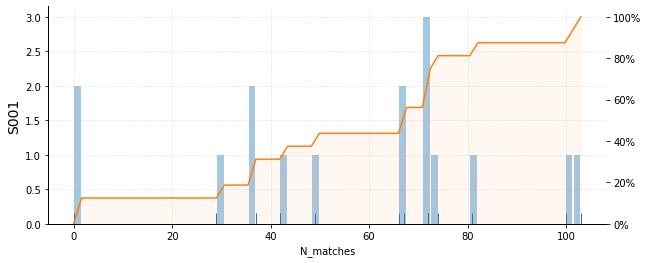

In [15]:
for (section, z), layer_pm in df_pm.groupby(['section', 'z']):

    # Compute cumulative distribution
    nbins = 64 if len(layer_pm) < 64 else distributions._freedman_diaconis_bins(layer_pm['N_matches'])
    hist, bins = np.histogram(layer_pm['N_matches'], bins=nbins)
    cumdist = np.cumsum(hist)

    # Plot distribution of N_matches
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.distplot(layer_pm['N_matches'], bins=nbins, kde=False, rug=True,
                 hist_kws={'rwidth': 0.85}, label=stack, ax=ax)

    # Plot cumulative distribution
    cumdist = cumdist / cumdist.max()
    cumdist = np.insert(cumdist, 0, 0)
    percent = np.linspace(0, 100, cumdist.size)
    axc = ax.twinx().twiny()
    axc.plot(percent, cumdist/cumdist.max(), color='C1')
    axc.fill_between(percent, 0, cumdist, color='C1', alpha=0.05)

    # Figure aesthetics
    ax.set_ylabel(f'{section}', fontsize=14)
    ax.grid(ls=':', alpha=0.5)
    axc.set_ylim(0, None)
    axc.axes.get_xaxis().set_ticks([])
    axc.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    sns.despine()

# Preview point matches DataFrame
df_pm = df_pm.infer_objects()
df_pm.sort_values('N_matches').drop(columns=['p_matches', 'q_matches']).groupby('section').apply(lambda x: x.head(6))

### 2.4 Inspect point matches
Plots that show point matches overlaid on top of the big EM and mm EM image tiles.

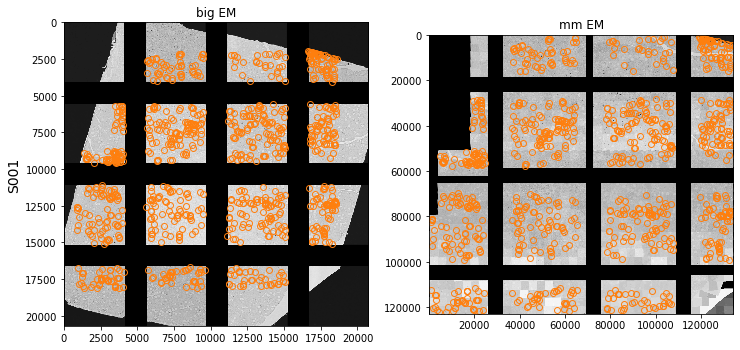

In [16]:
for (section, z), layer_pm in tqdm_notebook(df_pm.groupby(['section', 'z'])):

    # Set up figure
    ncols = 2
    fig, axes = plt.subplots(ncols=ncols, figsize=(6*ncols, 6))

    # Render section images
    for c, stack in enumerate(['big_EM', 'mm_EM']):

        # Set bounding box
        bounds = renderapi.stack.get_bounds_from_z(stack=stack,
                                                   z=z,
                                                   render=render)
        bb = [bounds['minX'],                   # x0
              bounds['minY'],                   # y0
              bounds['maxX'] - bounds['minX'],  # w
              bounds['maxY'] - bounds['minY']]  # h
        scale = 1024 / bb[2]

        # Render section images
        with warnings.catch_warnings():      # avoid loss of
            warnings.simplefilter('ignore')  # precision warning
            # Get oversized bounding box images
            image = img_as_uint(rgb2grey(renderapi.image.get_bb_image(stack, z, *bb, scale=scale, img_format='tif', render=render)))

        # Plot images
        extent = [bb[0], bb[0]+bb[2], bb[1], bb[1]+bb[3]]
        axes[c].imshow(image, extent=extent, origin='lower', cmap='Greys_r')

    # Plot point matches
    for i, pms in df_pm.iterrows():

        # Get translation by which to offset
        ptform = renderapi.tilespec.get_tile_spec(stack=pms['p_stack'],
                                                  tile=pms['pid'],
                                                  render=render).tforms[0]
        qtform = renderapi.tilespec.get_tile_spec(stack=pms['q_stack'],
                                                  tile=pms['qid'],
                                                  render=render).tforms[0]

        if len(pms['p_matches']):  # Skip over tile pairs w/o point matches
            # Overlay point matches as markers
            axes[0].plot(pms['p_matches'][:, 0]*ptform.M00 + ptform.B0,
                         pms['p_matches'][:, 1]*ptform.M11 + ptform.B1,
                         marker='o', color='C1', mfc='none', ls='')
            # Overlay point matches as markers
            axes[1].plot(pms['q_matches'][:, 0]*qtform.M00 + qtform.B0,
                         pms['q_matches'][:, 1]*qtform.M11 + qtform.B1,
                         marker='o', color='C1', mfc='none', ls='')

    # Axis aesthetics
    axes[0].set_ylabel(f'{section}', fontsize=14)
    axes[0].set_title('big EM')
    axes[1].set_title('mm EM')
    [ax.invert_yaxis() for ax in axes]

### 2.5 Optionally rerun `PointMatchClient`

In [17]:
df_tp_reruns = df_pm[df_pm['N_matches'] < 12].copy()
df_tp_reruns

,p_stack,q_stack,section,z,N_matches,pc,pr,qc,qr,pid,qid,p_matches,q_matches
2395,big_EM,mm_EM,S001,1.0,0,3,3,3,3,aad_big_EM-S001-00003x00003,mm_EM-S001-00003x00003,[],[]
2407,big_EM,mm_EM,S001,1.0,0,0,0,0,0,aap_big_EM-S001-00000x00000,mm_EM-S001-00000x00000,[],[]


In [18]:
match_params = MatchDerivationParameters(matchIterations=None,
                                         matchMaxEpsilon=25,        # maximal alignment error
                                         matchMaxNumInliers=None,
                                         matchMaxTrust=None,
                                         matchMinInlierRatio=0.05,  # minimal inlier ratio
                                         matchMinNumInliers=7,      # minimal number of inliers
                                         matchModelType='AFFINE',   # expected transformation
                                         matchRod=0.92)             # closest/next closest ratio
feature_params = FeatureExtractionParameters(SIFTfdSize=4,          # feature descriptor size
                                             SIFTmaxScale=0.50,     # (width/height *) maximum image size
                                             SIFTminScale=0.01,     # (width/height *) minimum image size
                                             SIFTsteps=7)           # steps per scale octave

sift_options = SiftPointMatchOptions(**{**match_params.__dict__,
                                        **feature_params.__dict__})

#### \*\****COMPUTATIONALLY EXPENSIVE*** \**

In [19]:
# N_cores = 10
# chunk_size = 6

# for section, layer_tp in tqdm_notebook(df_tp_reruns.groupby('section')):
    
#     grouping = np.arange(len(layer_tp)) // chunk_size
#     for i, chunk in tqdm_notebook(layer_tp.groupby(grouping)):
        
#         # Have to wrap up each tile pair all neat and nicelike
#         tp_chunk = [[tuple(tp)] for tp in chunk[['pid', 'qid']].values.tolist()]
        
#         # Set up pointmatch client
#         point_match_client_partial = partial(run_point_match_client,
#                                              p_stack=chunk['p_stack'].iloc[0],
#                                              q_stack=chunk['q_stack'].iloc[0],
#                                              collection=match_collection,
#                                              sift_options=sift_options,
#                                              render=render)
#         # Run point match client with `N_cores`
#         with renderapi.client.WithPool(N_cores) as pool:
#             pool.map(point_match_client_partial, tp_chunk)

## 3 Apply transforms
---

### 3.1 Compute affine transforms
The exact mapping from each big EM tile to each mini-montage is a combination of the
* Affine transform derived from `SIFT` point matches
* Scaling factor used to render the mini-montage.

In [20]:
# None for when there are no matches
df_pm['tforms'] = None

for i, pms in tqdm_notebook(df_pm.iterrows(), total=len(df_pm)):

    # Skip over tile pairs for which there are no point matches
    if len(pms['p_matches']):

        # Compute point-match-based affine transform using `RANSAC`
        src = pms['p_matches']
        tgt = pms['q_matches']
        model, inliers = ransac((src, tgt),
                                model_class=AffineSkimage,
                                min_samples=7,          # not sure how optimal
                                residual_threshold=25)  # these parameters are
        # Convert AffineSkimage to AffineRender
        at_pm = AffineRender()
        at_pm.M = model.params

        # Compute scaling-factor-based affine transform
        tform_mm_EM = renderapi.tilespec.get_tile_spec(stack=pms['q_stack'],
                                                       tile=pms['qid'],
                                                       render=render).tforms[0]
        at_scaling = AffineRender(M00=tform_mm_EM.M00, M01=0, B0=tform_mm_EM.B0,
                                  M10=0, M11=tform_mm_EM.M11, B1=tform_mm_EM.B1)

        # Fill in point matches DataFrame
        df_pm.at[i, 'tforms'] = [at_pm, at_scaling]

### 3.2 Apply transforms to big EM and FM stacks
The exact transform and exact order of transforms here is super duper important. Also the fact that the poinmatch-based transform must be inverted. Also the fact that the initial big EM transform is tossed out.

In [21]:
# Iterate through FM (overlay) stacks + big EM
stacks_2_correlate = ['big_EM'] + [stack for stack in stacks_FM if 'overlaid' in stack]
stacks_correlated = []
for stack in tqdm_notebook(stacks_2_correlate):

    # Loop through transform data computed above
    tile_specs_correlated = []
    for i, pms in df_pm.iterrows():

        # Pick out tileId from stack, column, and row (should be unique)
        tileId = stack_data[(stack_data['stack'] == stack) & \
                            (stack_data['imageCol'] == pms['pc']) & \
                            (stack_data['imageRow'] == pms['pr'])]['tileId'].iloc[0]

        # Append transforms to each `TileSpec`
        if pms['tforms'] is not None:  # Skip over tiles w/o a correlative transform
            ts = renderapi.tilespec.get_tile_spec(stack=stack,
                                                  tile=tileId,
                                                  render=render)
            # **Toss out initial tform** (while keeping overlay transform if FM stack)
            ts.tforms = ts.tforms[:-1]
            # Add [point-match, scaling] transforms
            ts.tforms.extend(pms['tforms'])
            # Append `TileSpec`
            tile_specs_correlated.append(ts)

    # Create correlated stacks
    stack_correlated = f'{stack}_correlated'
    renderapi.stack.create_stack(stack=stack_correlated,
                                 render=render)
    # Import transformed big EM `TileSpec`s
    renderapi.client.import_tilespecs(stack=stack_correlated,
                                      tilespecs=tile_specs_correlated,
                                      render=render)
    # Set stack state to COMPLETE
    renderapi.stack.set_stack_state(stack=stack_correlated,
                                    state='COMPLETE',
                                    render=render);
    # Collect correlated stacks
    stacks_correlated.append(stack_correlated)

### 3.3 Inspect alignment

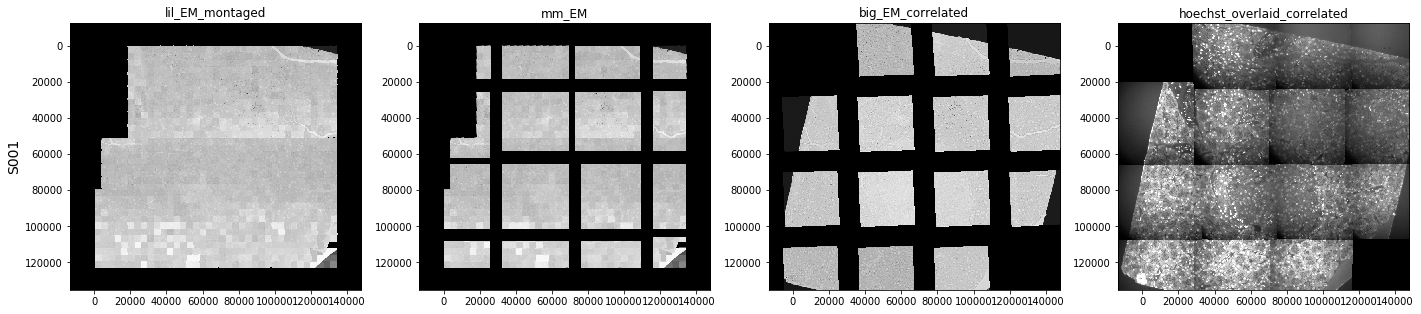

In [22]:
for (section, z), layer in tqdm_notebook(df_pm.groupby(['section', 'z'])):

    # Set up figure
    ncols = 4
    fig, axes = plt.subplots(ncols=ncols, figsize=(6*ncols, 6))

    # Set oversized bounding box based on lil_EM_montaged bounds
    pct = 10  # %
    bounds = renderapi.stack.get_bounds_from_z(stack='lil_EM_montaged',
                                               z=z,
                                               render=render)
    x = bounds['minX']
    y = bounds['minY']
    w = bounds['maxX'] - bounds['minX']
    h = bounds['maxY'] - bounds['minY']
    bb = [x - (w * pct/100),
          y - (h * pct/100),
          w + (2*pct/100 * w),
          h + (2*pct/100 * h)]
    scale = 1024 / bb[2]

    # Stacks to inspect
    stacks = ['lil_EM_montaged', 'mm_EM'] + stacks_correlated
    for c, stack in enumerate(stacks):
        # Render section images
        with warnings.catch_warnings():      # avoid loss of
            warnings.simplefilter('ignore')  # precision warning
            # Get oversized bounding box images
            bb_image = img_as_uint(rgb2grey(renderapi.image.get_bb_image(
                stack, z, *bb, scale=scale, img_format='tif', render=render)))

        # Plot images
        extent = [bb[0], bb[0]+bb[2], bb[1], bb[1]+bb[3]]
        axes[c].imshow(bb_image, extent=extent, origin='lower', cmap='Greys_r')
        axes[c].set_title(f'{stack}')

    # Axis aesthetics
    axes[0].set_ylabel(f'{section}', fontsize=14)
    [ax.invert_yaxis() for ax in axes]